#  Code for 2D staggered Lagrangian method in Cartersian coordinates

## Control equations

一般形式下，弹塑性流体控制方程为：

质量方程：
\begin{equation}
  \frac{dm}{dt}=0
  \end{equation}
动量方程：
\begin{equation}
  \frac{d\rho \mathbf{u}}{dt}= \nabla \cdot  \mathbf{\Pi} 
\end{equation}

能量方程：
\begin{equation}
 \rho \frac{de}{dt}= \mathbf{\sigma} \cdot \mathbf{\varepsilon}
\end{equation}

\section{二维控制方程}

运动方程：
\begin{equation}
  \frac{d(r,z)}{dt}=(u,v)
\end{equation}

质量守恒：
\begin{equation}\label{eq:38}
  \frac{dm}{dt}=0
\end{equation}

动量守恒方程：
\begin{equation}\label{eq:3}
  \begin{array}{l}
	\displaystyle \rho \frac{du}{dt}=\frac{\partial \sigma _{rr}}{\partial r}+ \frac{\partial s_{rz}}{\partial z}\\[0.3cm]
  \displaystyle \rho \frac{dv}{dt}=\frac{\partial \sigma _{zz}}{\partial z}+ \frac{\partial s_{rz}}{\partial r}\\
  \end{array}
  \end{equation}

能量守恒方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \rho \frac{de}{dt}=\sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+s_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle = -p\frac{dV}{dt}+ s_{rr}\frac{\partial u}{\partial r}+s_{zz}\frac{\partial v}{\partial z}+s_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)\\
	\end{array}
	\end{equation}

本构方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \frac{ds_{rr}}{dt}=2\mu \left(\frac{\partial u}{\partial r}-\frac{1}{3}\nabla \cdot \vec{u} \right) +s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{zz}}{dt}=2\mu \left(\frac{\partial v}{\partial z}-\frac{1}{3}\nabla \cdot \vec{u} \right) -s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{rz}}{dt}=\mu \left(\frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right) + \frac{s_{rr}-s_{zz}}{2}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\
  \end{array}
  \end{equation}

Von Mises屈服条件：
\begin{equation}
  \frac{3}{2}(s_{rr}^2+s_{zz}^2+s_{\theta \theta}^2+2s_{xy}^2)\le (Y^0)^2
\end{equation}







$$ s_{\theta\theta} = - (s_{rr} +s_{zz}) $$

## Compatible Staggered Discretization

<img src="Grid.png" width = "800" height = "400" div align=center /> 

<img src="cellpoint.png" width = "800" height = "400" div align=center />

### Quatities:

On point: ($x_p$,$y_p$), ($u_p$,$v_p$)

Zonal:  $V_z$, $\rho_z$, $m_z$, $e_z$, $p_z$

By the relation 
$$\frac{dm_z}{dt} =0$$
we have 
$$\rho_z(t) = m_z/V_z(t)$$

Also 
$$d(x_p)/dt = u_p, \quad d(y_p)/dt = v_p$$

In [1]:
struct Const
    Y0 ::Float64 #Yielding strength
    ρ0 ::Float64 
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end


In [2]:
mutable struct Var
    r::Array{Float64,1}
    z::Array{Float64,1}
    u::Array{Float64,1}
    v::Array{Float64,1}
    ρ::Array{Float64,1}
    p::Array{Float64,1}
    s::Array{Float64,2} # σ[1] = σrr σ[2] = σzz σ[3] = σrz
end    

In [3]:
struct prb
    tt::Float64
    sf::Float64
end

### Point mass 

Point mass $m_p$ is used to solve point momentum $\mu_p = m_p \bf{u}_p$ and kinetic energy $K_p = m_p \frac{\bf{u}_p^2}{2}$

<img src="Ins.jpg" width = "200" height = "400" div align=center /> 

$$m_p = \sum_{z\in Z(p)} A_z^p \rho^p_z$$

$$\rho_z(t) = m_z/V_z(t)$$

In [4]:
function MassAndDens(mz::Array{Float64,1},x::Array{Float64,1},y::Array{Float64,1})
    
    Ic, = size(mz)
    Ip, = size(Tc)
    Asbz = zeros(Float64,4)
    ρ = zeros(Float64,Ic)
    mp = zeros(Float64,Ip)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4)
    for i in 1:Ic
        xz[1:4] = x[Tp[i,1:4]]
        yz[1:4] = y[Tp[i,1:4]]
        Asbz = A_z(xz,yz)
        Az = sum(Asbz)
        ρ[i] = mz[i]/Az
        
        for j = 1:4
            ip = Tp[i,j]
            mp[ip] = mp[ip] + Asbz[j]*ρ[i]
        end
    end
   # @show mp
    return ρ,mp   
end

MassAndDens (generic function with 1 method)


$$ A_z^1 = \frac{5A_{41}+5A_{12}+A_{23}+A_{34}}{12}$$
$$ A_z^2 = \frac{A_{41}+5A_{12}+5A_{23}+A_{34}}{12}$$
$$ A_z^3 = \frac{A_{41}+A_{12}+5A_{23}+5A_{34}}{12}$$
$$ A_z^4 = \frac{5A_{41}+A_{12}+A_{23}+5A_{34}}{12}$$

In [5]:
function A_z(xz::Array{Float64,1},yz::Array{Float64,1}) 
    A =zeros(Float64,4)
    xc= sum(xz[i] for i in 1:4)/4
    yc= sum(yz[i] for i in 1:4)/4
    
    A41 = Area3(xz[4],xz[1],xc,yz[4],yz[1],yc)
    A12 = Area3(xz[1],xz[2],xc,yz[1],yz[2],yc)
    A23 = Area3(xz[2],xz[3],xc,yz[2],yz[3],yc)
    A34 = Area3(xz[3],xz[4],xc,yz[3],yz[4],yc)

    A[1] = (5A41+5A12+A23+A34)/12
    A[2] = (A41+5A12+5A23+A34)/12
    A[3] = (A41+A12+5A23+5A34)/12
    A[4] = (5A41+A12+A23+5A34)/12
    
#    A[1] = (A41+A12+A23+A34)/4
#    A[2] = (A41+A12+A23+A34)/4
#    A[3] = (A41+A12+A23+A34)/4
#    A[4] = (A41+A12+A23+A34)/4
    
    return A
end

A_z (generic function with 1 method)

<img src="n12.png" width = "300" height = "300" div align=center />

$$\overrightarrow{n}_{12} = \frac{1}{L_{12}}(y_2- y_1, x_1-x_2)  $$

$$\overrightarrow{\tau}_{12} = \frac{1}{L_{12}}(x_2- x_1, y_2-y_1)  $$

$$ \mathbf{F_1}  = \frac{1}{2}  \left[ -\sigma_{rr}(z_2-z_4)+ s_{rz}(r_2 -r_4), \sigma_{zz}(r_2-r_4) +s_{rz}(z_4 -z_2) , \right] $$ 

In [6]:
function force_zone(x,y,u,v,ρ,p,σ) #(r,z)
   
    Fx = zeros(Float64,4)
    Fy = zeros(Float64,4)
    
    
    Fx[1] = 0.5(σ[1]*(y[4] - y[2]) + σ[3]*(x[2] - x[4]))
    Fy[1] = 0.5(σ[3]*(y[4] - y[2]) + σ[2]*(x[2] - x[4]))
    
    Fx[2] = 0.5(σ[1]*(y[1] - y[3]) + σ[3]*(x[3] - x[1]))
    Fy[2] = 0.5(σ[3]*(y[1] - y[3]) + σ[2]*(x[3] - x[1]))
    
    Fx[3] = 0.5(σ[1]*(y[2] - y[4]) + σ[3]*(x[4] - x[2]))
    Fy[3] = 0.5(σ[3]*(y[2] - y[4]) + σ[2]*(x[4] - x[2]))
    
    Fx[4] = 0.5(σ[1]*(y[3] - y[1]) + σ[3]*(x[1] - x[3]))
    Fy[4] = 0.5(σ[3]*(y[3] - y[1]) + σ[2]*(x[1] - x[3]))
      
    ex,ey = hourglass_viscosity(x, y, u, v, ρ, p,σ) 

    Fx = Fx .+ ex
    Fy = Fy .+ ey
    
    return Fx,Fy
end           

force_zone (generic function with 1 method)

\begin{equation}
  \begin{aligned}
	&\displaystyle \rho \frac{de}{dt}= \mathbf{\sigma} \cdot \mathbf{\varepsilon}\\ 
	&=
	\sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+\sigma_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)
	\end{aligned}
	\end{equation}
    
\begin{equation}
  \begin{aligned}
	&\displaystyle M \frac{de}{dt}=  
\int_{\Omega} \sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+\sigma_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)d\Omega
	\end{aligned}
	\end{equation}


\begin{equation}
  \begin{aligned}
\int_{\Omega}  \frac{\partial u}{\partial r} d\Omega&=  -\oint_{\partial \omega}u dz\\
  &= \frac{1}{2} \left((u_1-u_3)(z_2-z_4)+(u_2-u_4)(z_3-z_1)\right)
  \end{aligned}
\end{equation}

\begin{equation}
  \begin{aligned}
\int_{\Omega}  \frac{\partial u}{\partial z} d\Omega&= \oint_{\partial \omega}u dy\\
  &= -\frac{1}{2} \left((u_1-u_3)(r_2-r_4)+(u_2-u_4)(r_3-r_1)\right)
  \end{aligned}
\end{equation}

$$ \frac{\partial u}{\partial x}  \approx \frac{1}{2A}((u_1-u_3)(y_2-y_4)+(u_2-u_4)(-y_1+y_3))$$ 

$$ \frac{\partial v}{\partial y}  \approx -\frac{1}{2A}((v_1-v_3)(x_2-x_4)+(v_2-v_4)(-x_1+x_3))$$ 

对于节点
$$ \rho \frac{d \mathbf{u}}{dt} = - \nabla p$$

$$m_p \frac{d\bf{u}_p}{dt} = \sum_{p\in P(z)} \bf{F}_z^p$$

$$F_z^1 = \mathbf{F}_1 + c\mathbf{e}_1$$

本构方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \frac{ds_{rr}}{dt}=2\mu \left(\frac{\partial u}{\partial r}-\frac{1}{3}\nabla \cdot \vec{u} \right) +s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{zz}}{dt}=2\mu \left(\frac{\partial v}{\partial z}-\frac{1}{3}\nabla \cdot \vec{u} \right) -s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{rz}}{dt}=\mu \left(\frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right) - \frac{s_{rr}-s_{zz}}{2}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\
  \end{array}
  \end{equation}

Von Mises屈服条件：
\begin{equation}
  \frac{3}{2}(s_{rr}^2+s_{zz}^2+s_{\theta \theta}^2+2s_{xy}^2)\le (Y^0)^2
\end{equation}


In [7]:
function rhs(var::Var)
    μ = con1.μ
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ic, = size(Tp)
    Ip, = size(Tc)
    rhsu = zeros(Float64,Ip)
    rhsv = zeros(Float64,Ip) 
    rhse = zeros(Float64,Ic)
    rhss = zeros(Float64,Ic,3)
    σ = zeros(Float64,Ic,3)
    
    σ[:,1] = s[:,1] - p[:]
    σ[:,2] = s[:,2] - p[:]
    σ[:,3] = s[:,3] 
    
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
    for i in 1:Ic
        for j =1:4
            rcell[j] = r[Tp[i,j]]
            zcell[j] = z[Tp[i,j]]
            ucell[j] = u[Tp[i,j]]
            vcell[j] = v[Tp[i,j]]
        end
        Az = sum(A_z(rcell,zcell))
        Fx,Fy = force_zone(rcell,zcell,ucell,vcell,ρ[i],p[i],σ[i,1:3])   
       # @show Fx
        ∂u_∂r,∂u_∂z = ∂uv(rcell,zcell, ucell)
        ∂v_∂r,∂v_∂z = ∂uv(rcell,zcell, vcell)
        rhse[i] = σ[i,1]*∂u_∂r + σ[i,2]*∂v_∂z+σ[i,3]*(∂u_∂z + ∂v_∂r)
        for j = 1:4
            ip = Tp[i,j]
            rhsu[ip] +=  Fx[j]
            rhsv[ip] +=  Fy[j]
        end  
        ∇u = ∂u_∂r + ∂v_∂z
    
        rhss[i,1] =  (2μ*(2/3*∂u_∂r - 1/3*∂v_∂z) + σ[i,3]*(∂u_∂z - ∂v_∂r)) ./Az
        rhss[i,2] =  (2μ*(2/3*∂v_∂z - 1/3*∂u_∂r) - σ[i,3]*(∂u_∂z - ∂v_∂r)) ./Az
        rhss[i,3] =   (μ*(∂u_∂z+∂v_∂r)  -   (σ[i,1] - σ[i,2])*(∂u_∂z - ∂v_∂r)) ./Az     
    #    @show rhsu 
    end
    
    return rhse, rhsu,rhsv,rhss

end     

rhs (generic function with 1 method)

$$ \mathbf{S} = \mathbf{S} \times \text{min} \left(1,Y_0/\sqrt{\frac{3}{2}\mathbf{S}:\mathbf{S}}\right)$$

In [8]:
function yield_s!(s,con)
    Y0 = con.Y0
    I, = size(s)
    for i in 1:I
         sums = s[i,1]^2 +s[i,2]^2 +2*s[i,3]^2 +(s[i,1]+s[i,2])^2
        for j = 1:3
       
        s[i,j] = s[i,j] * min(1,Y0/√(3/2*sums))
            end 
    end
    return s
end

yield_s! (generic function with 1 method)

In [9]:
function predictor_corrector2nd(dt,var::Var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,r,z)
    e = p_to_e(ρ, p,con1)    
    p = artificial_viscosity!(r,z,u,v,ρ,p)
    var = Var(r, z, u, v, ρ, p, s)
    rhse, rhsu,rhsv,rhss = rhs(var)
    rhsu,rhsv = Bound(rhsu,rhsv,var)
    
    s = yield_s!(s,con1)
    r₀ =  r + dt*u
    z₀  = z + dt*v
    u₀  = u + dt*(rhsu ./ mp)
    v₀  = v + dt*(rhsv ./ mp)
    e₀  = e + dt*(rhse ./ mz) 
    s₀  = s + dt*rhss
  #  @show rhsu
    s₀ = yield_s!(s₀,con1)
    
    ρ,mp = MassAndDens(mz,r₀,z₀)
    p = e_to_p(ρ,e₀,con1)
    
    p = artificial_viscosity!(r₀,z₀,u₀,v₀,ρ,p) 
    
    var = Var(r₀, z₀, u₀, v₀, ρ, p, s)
    rhse₀,rhsu₀,rhsv₀,rhss₀ = rhs(var)
   #  @show u₀,rhsu₀
    rhsu₀,rhsv₀ = Bound(rhsu₀,rhsv₀,var)
  #  @show s[:,1]
    r +=  0.5dt*(u + u₀)
    z +=  0.5dt*(v + v₀)
    u +=  0.5dt*(rhsu + rhsu₀) ./ mp
    v +=  0.5dt*(rhsv + rhsv₀) ./ mp
    e +=  0.5dt*(rhse + rhse₀) ./ mz
    s  += 0.5dt*(rhss + rhss₀)
    s = yield_s!(s,con1)
    ρ,mp = MassAndDens(mz,r,z)
    p = e_to_p(ρ,e,con1) 
    var = Var(r,z,u,v,ρ,p,s) 
    return var
end

predictor_corrector2nd (generic function with 1 method)

In [10]:
function fη(ρ,c::Const)
    η = ρ/c.ρ0
    fη=(η .-1.0) .* (η .-c.Γ0*(η .-1.0)/2.0) ./ (η .-c.s0*(η .-1)) .^2
end

function fηη(ρ,c::Const)
    η = ρ/c.ρ0
    fηη=(η .+(c.s0-c.Γ0) .* (η .-1)) ./(η .-c.s0*(η .- 1)) .^3
end

fηη (generic function with 1 method)

In [11]:
function Euler1st(dt,mz,p,var::Var)
    r,z,u,v,ρ,σ = var.r,var.z,var.u,var.v,var.ρ,var.σ
    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,r,z)
  
     e = p_to_e(p, ρ,con1)
     
     p = artificial_viscosity!(p,var)
        
     σ[:,1] = s[:,1] .- p[:]
     σ[:,2] = s[:,2] .- p[:]
     σ[:,3] = s[:,3]
    
     rhse, rhsu,rhsv,rhss = Rhs(r,z,u, v,ρ, σ)
    
     rhsu,rhsv = Bound(rhsu,rhsv,r,z,u, v,ρ, p)
    
    x  +=  dt*u
    y  +=  dt*v
    u  += dt*(rhsu ./ mp)
    v  += dt*(rhsv ./ mp)
    e  += dt*(rhse ./ mz)
    s  += dt*(rhss ./ mz)

    ρ,mp = MassAndDens(mz,r,z)
    
    p = eTop(e, ρ,con1)

    return u,v,x,y,p,ρ
end


Euler1st (generic function with 1 method)

### Boundary force

If one edge of a cell is a free boundary, then $f$ on the points is zero. As we have add it in RHs(), we need to remove it by resolve it again. Different from RHs(), at every point of a cell the force is composited by two parts on different edges. This is distinguished by $k$ when $k = 1$ the boundary is on y direction, forces on 12 and 34 boundary must be subtracted. When $ k =2$ the boundary is on x direction, subtract forces on 41, 23. 

In [12]:
function Bound(rhsu,rhsv,var)
    Ip, = size(Tc)
    Ib, = size(Tb)
   
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
    ip1 = zeros(Int,4)
    σ = zeros(Float64,3)
    for i in 1:Ib
        
        ic = Tb[i,1]        
        rcell[1:4] = r[Tp[ic,1:4]]
        zcell[1:4] = z[Tp[ic,1:4]]
        ucell[1:4] = u[Tp[ic,1:4]]
        vcell[1:4] = v[Tp[ic,1:4]]
          
        σ[1] = s[ic,1] - p[ic]
        σ[2] = s[ic,2] - p[ic]
        σ[3] = s[ic,3]
        
        ex,ey = hourglass_viscosity(rcell, zcell, ucell, vcell, ρ[ic]
                                    , p[ic],s[ic,:])
        i₁ = Tb[i,2]
        i₂ = i₁+1
        if i₁ == 4
            i₂ = 1
        end
        nx = zcell[i₂] -zcell[i₁]
        ny = rcell[i₁] -rcell[i₂]
        p0 = 1.0e-5
        for j in (i₁,i₂)
           
            ip = Tp[ic,j]
            if Tb[i,3] == 1
                Fx = -σ[1]*nx/2 -σ[3]*ny/2+ex[j]*nx^2/(nx^2+ny^2)  #+ex[j] 
                Fy = -σ[3]*nx/2 -σ[2]*ny/2+ey[j]*ny^2/(nx^2+ny^2)
                Fx1 = (Fx*nx+Fy*ny)*nx/(nx^2+ny^2)
                Fy1 = (Fx*nx+Fy*ny)*ny/(nx^2+ny^2)
                Fx = Fx- Fx1
                Fy = Fy - Fy1
                
                Fx1 =  p0*nx/2 #+ex[j]*nx^2/(nx^2+ny^2) 
                Fy1 =  p0*ny/2 #+ey[j]*ny^2/(nx^2+ny^2)
             
                rhsu[ip] +=  -Fx -Fx1
                rhsv[ip] +=  -Fy -Fy1
            end
            if Tb[i,3] == 2 # boundary
                Fx = -σ[1]*nx/2 -σ[3]*ny/2 +ex[j]*nx^2/(nx^2+ny^2) 
                Fy = -σ[3]*nx/2 -σ[2]*ny/2  +ey[j]*ny^2/(nx^2+ny^2)
                rhsu[ip] -= Fx
                rhsv[ip] -= Fy
                u[ip] = u[ip]*ny^2/(nx^2 +ny^2)
                v[ip] = v[ip]*nx^2/(nx^2 +ny^2)
            end
            if Tb[i,3] == 3 # boundary
                uL = 20

                u[ip] = uL #*nx/(nx^2 +ny^2)
                 Fx = -σ[1]*nx/2 -σ[3]*ny/2 +ex[j]*nx^2/(nx^2+ny^2) 
                Fy = -σ[3]*nx/2 -σ[2]*ny/2  +ey[j]*ny^2/(nx^2+ny^2)
                rhsu[ip] -= Fx
                rhsv[ip] -= Fy
            end  
        end
        
        if Tb[i,3] == 4
            for j in (i₁,i₂)
                ip = Tp[ic,j]
                Fx = -σ[1]*nx/2 -σ[3]*ny/2 +ex[j]*nx^2/(nx^2+ny^2)
                Fy = -σ[3]*nx/2-σ[2]*ny/2  +ey[j]*ny^2/(nx^2+ny^2)
                Fx1 = (Fx*nx+Fy*ny)*nx/(nx^2+ny^2)
                Fy1 = (Fx*nx+Fy*ny)*ny/(nx^2+ny^2)
                rhsu[ip] -= Fx1
                rhsv[ip] -= Fy1
                
                u[ip] = u[ip]*ny^2/(nx^2 +ny^2)
                v[ip] = v[ip]*nx^2/(nx^2 +ny^2)
  
             end        
        end        
    end 

    return rhsu, rhsv
end  

Bound (generic function with 1 method)

### EOS 
$$ e = \frac{p}{(\gamma-1)\rho}$$

In [13]:
function p_to_e(ρ,p,con)
    c=con
    ei = (p .- c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function e_to_p(ρ,ei,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei .+ c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

e_to_p (generic function with 1 method)

In [40]:
function CFL(SF,var)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ic, = size(ρ)
    cflmin = 1.e9
      cfl = 0 
    for i in 1:Ic
        cfl =0
        u2max = 0
        u2=0.0
        for j = 1:4
            ip = Tp[i,j]
            u2 = u[ip]^2+v[ip]^2
            if u2 > u2max ; u2max = u2; end
        end
        
        dlmin = (r[Tp[i,4]] - r[Tp[i,1]])^2+(z[Tp[i,4]]-z[Tp[i,1]])^2
       
        for j=1:3
            dl= (r[Tp[i,j+1]] - r[Tp[i,j]])^2+(z[Tp[i,j+1]]-z[Tp[i,j]])^2
            if dl < dlmin; dlmin=dl; end
        end
        c = sound([ρ[i],u[i],p[i],min(s[i,1],s[i,2])],con1)
        cfl = √(dlmin)/(√(u2max)+c)
        if cfl < cflmin; cflmin = cfl; end
    end
 #   @show cflmin
    dt = cflmin*SF
    return dt
end 
        

CFL (generic function with 1 method)

In [43]:
function CFL(SF,var)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ic, = size(ρ)
    cflmin = 1.e9
      cfl = 0 
    for i in 1:Ic
        cfl =0
        u2max = 0
        u2=0.0
        for j = 1:4
            ip = Tp[i,j]
            u2 = u[ip]^2+v[ip]^2
            if u2 > u2max ; u2max = u2; end
        end
        
        dl1 = (r[Tp[i,3]] - r[Tp[i,1]])^2+(z[Tp[i,3]]-z[Tp[i,1]])^2
        dl2 = (r[Tp[i,2]] - r[Tp[i,4]])^2+(z[Tp[i,2]]-z[Tp[i,4]])^2
        area = area_quadrangle(r[Tp[i,1:4]],z[Tp[i,1:4]])
        dlmin = area / √(max(dl1,dl2))
        
        c = sound([ρ[i],u[i],p[i],min(s[i,1],s[i,2])],con1)
        cfl = dlmin/(√(u2max)+c)
        if cfl < cflmin; cflmin = cfl; end
    end
 #   @show cflmin
    dt = cflmin*SF
    return dt
end 
        

CFL (generic function with 1 method)

In [15]:
function sound(uo::Array{Float64,1},con::Const,EoP::Int=1)
    a0,ρ0,Γ0,Y0,μ  = con.a0,con.ρ0,con.Γ0,con.Y0,con.μ
    ρ,uu,p,sxx   = uo[1:4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
    if EoP == 2
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx)
        return c
    else
       #  @show a2,ρ0/ρ^2,4.0/3*μ/ρ
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
       
        return c
    end
end

sound (generic function with 2 methods)

In [42]:
function TimeSolve(var,mz)
    tt= problem.tt
    sf =problem.sf
    t= 0.0
    t₁ = tt/100
    t₂ = t₁
    while t<tt   
#for i in 1:1
        dt=CFL(sf,var)
  #      @show dt
        if t+dt>tt
           dt = tt-t
        end
        
        var = predictor_corrector2nd(dt,var,mz)
        t += dt
        if t > t₁
            println(t)
            t₁ += t₂
        end
    end
    return var
end

TimeSolve (generic function with 1 method)

## Artificial Viscosity 

Use the strain rate to construct the artificial viscosity 
$$\frac{ds}{dt} = \frac{\partial u}{\partial x}  + \frac{\partial v}{\partial y} $$


Then the artificial viscosity can be written as
$$ q_w = \left\{ \begin{align}
\alpha L \rho \left( \frac{ds}{dt} \right)^2 +  \beta L^2 \rho c \left|\frac{ds}{dt}\right|, \quad \text{if}  \quad \frac{ds}{dt}< 0,\\
0, \quad \text{if} \quad \frac{ds}{dt}\ge 0. \\
\end{align}
\right.
$$
where $\alpha = 0.6$, $\beta = 2.0 $ and $c$ is the sonic speed.

$L$ is the reference length, and constructed as
$$L = A/L_{\text{max}} $$

$$L_{\text{max}} = \text{max}(L_{13},L_{24})$$


In [17]:
function artificial_viscosity_c!(x,y,u,v,ρ,p)
    xc = sum(x[i] for i in 1:4)/4
    yc = sum(y[i] for i in 1:4)/4
    
    ∂u_∂x,tmp = ∂uv(x,y,u)
    tmp,∂v_∂y = ∂uv(x,y,v)
    c = sound([ρ,0.0,p,0.0],con1)
    Lmax = max(√((x[3] - x[1])^2+(y[3] - y[1])^2) ,√((x[2] - x[4])^2+(y[2] - y[4])^2) )  
    A = area_quadrangle(x, y)
    L = A/Lmax 

    if ∂u_∂x + ∂v_∂y> 0
        q = 0
    else
        q = 0.6ρ*L*c*(abs(∂u_∂x+∂v_∂y))/A +2.0L^2*ρ*((∂u_∂x+∂v_∂y)^2)/A^2 
    end
    return p+q
end

artificial_viscosity_c! (generic function with 1 method)

$$b_2 \rho Lc \frac{\partial u}{\partial x} - b_{12}\rho L^2 \left(\frac{\partial u}{\partial x}\right)^2$$

In [18]:
function artificial_viscosity!(r,z,u,v,ρ,p)
    I, = size(Tp)
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
   
    for i in 1:I
        for j in 1:4
            ip = Tp[i,j]
            rcell[j] = r[ip]
            zcell[j] = z[ip]
            ucell[j] = u[ip]
            vcell[j] = v[ip]
        end
        p[i] = artificial_viscosity_c!(rcell,zcell,ucell,vcell,ρ[i],p[i])
    end
    
        return p
        
    end       

artificial_viscosity! (generic function with 1 method)

In [19]:
function l_viscosity(x,y,α)
    xc = sum(x)/4; yc = sum(y)/4
    d = zeros(Float64,4)
    for i in 1:4
    d[i] = distance(x[i],y[i],xc,yc,α)
    end
    A = A_z(x, y)
    L = 2sum(A)/sum(d)
    return L
end

l_viscosity (generic function with 1 method)

#### distance from  Point to line 
Line: $$ (xc -cos \alpha )(x-xc) = (yc-sin \alpha)(y-yc)$$
point: $x,y$

In [20]:
function distance(x,y,xc,yc,α)
    d = abs((xc - cosd(α)) * (x .-xc)- (yc-sind(α))*(y .- yc))/√((xc-cosd(α))^2+(yc-sind(α))^2)
    return d
end

distance (generic function with 1 method)

### 沙漏粘性 Hourglass

$$ \text{hg}_x = u_1 -u_2 + u_3 - u_4$$ 
$$ \text{hg}_x = v_1 -v_2 + v_3 - v_4$$ 

$$ e_{1x} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{1y} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{2x} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{2y} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{3x} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{3y} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{4x} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{4y} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

In [21]:
function hourglass_viscosity(x,y,u,v,ρ,p,s)
    hgx = u[1] - u[2] + u[3] -u[4]
    hgy = v[1] - v[2] + v[3] -v[4]
    
    ex =zeros(Float64,4)
    ey =zeros(Float64,4)
    A = area_quadrangle(x,y)
    c = sound([ρ,0.0,p,min(s[1],s[2])], con1)
 #   @show c
    q = 0.6 # coefficient of hourglass viscosity 0.01 - 0.5 ?
    ex[1] = -0.25q*ρ*c*√(A)*hgx
    ey[1] = -0.25q*ρ*c*√(A)*hgy
    
    ex[2] = -ex[1]
    ey[2] = -ey[1]
    
    ex[3] = ex[1]
    ey[3] = ey[1]
    
    ex[4] = ex[2]
    ey[4] = ey[2]
    
   ex .= 0
   ey .= 0
 #   @show ex,ey
    return ex, ey
end

hourglass_viscosity (generic function with 1 method)

In [22]:
function area_quadrangle(x::Array{Float64,1},y::Array{Float64,1}) 
   
    xc= sum(x[i] for i in 1:4)/4
    yc= sum(y[i] for i in 1:4)/4
    
    A41 = Area3(x[4],x[1],xc,y[4],y[1],yc)
    A12 = Area3(x[1],x[2],xc,y[1],y[2],yc)
    A23 = Area3(x[2],x[3],xc,y[2],y[3],yc)
    A34 = Area3(x[3],x[4],xc,y[3],y[4],yc)
    
    A = A12 + A23 +A34 +A41
    return A
end

area_quadrangle (generic function with 1 method)

In [23]:
function Area3(x1,x2,x3,y1,y2,y3)
    return abs((x1*y2+y1*x3+x2*y3-x1*y3-y1*x2-y2*x3)/2)
end

Area3 (generic function with 1 method)

###  $\frac{\partial (u,v)}{\partial (x,y)}$

we use the diffences between 1 and 3 points and 2 and 4 points to solve the partial differences approximately, as
$$ \frac{\partial u}{\partial x}  \approx \frac{1}{2A}((u_1-u_3)(y_2-y_4)+(u_2-u_4)(-y_1+y_3))$$ 

$$ \frac{\partial v}{\partial y}  \approx -\frac{1}{2A}((v_1-v_3)(x_2-x_4)+(v_2-v_4)(-x_1+x_3))$$ 
Similar process to $\frac{\partial u}{\partial y}$,$\frac{\partial v}{\partial x}$ and $\frac{\partial v}{\partial y}$

In [24]:
function ∂uv(x,y,u)
    ∂u_∂x = 0.5(u[1]-u[3])*(y[2]-y[4]) + 0.5(u[2]-u[4])*(y[3]-y[1])
    ∂u_∂y = -0.5(u[1]-u[3])*(x[2]-x[4]) - 0.5(u[2]-u[4])*(x[3]-x[1])
    return ∂u_∂x,∂u_∂y
end

∂uv (generic function with 1 method)

## Output function

In [25]:
function cell_coordinate(x,y)
    Ip, = size(Tc)
    Ic, = size(Tp)
    xc = zeros(Float64,Ic)
    yc = zeros(Float64,Ic)
    
    for i in 1:Ic
        for j = 1:4
            ip = Tp[i,j] 
            xc[i] += x[ip]/4
            yc[i] += y[ip]/4
        end
        
    end
    
    return xc,yc
end

cell_coordinate (generic function with 1 method)

In [26]:
function outputline(Ix,Iy,var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    I, = size(ρ)
    
    uline =  zeros(Float64,Ix)
    rline =  zeros(Float64,Ix)
    zline =  zeros(Float64,Ix)
    ρline =  zeros(Float64,Ix)        
    pline =  zeros(Float64,Ix)  
    sline = zeros(Float64,Ix,3)
    for i in 1:Ix
        j = Int(floor(Iy/2))
            ip = i+(j-1 ) *(Ix+1)
            ic =i+(j-1)*Ix
            uline[i] = u[ip]
            rline[i]  = r[ip]
            ρline[i]  = ρ[ic]
            pline[i] = p[ic]
           # σline[i,:] .= σ[ic,:]
            sline[i,:] = s[ic,:]
    end
    return rline,uline,ρline,pline,sline
end

outputline (generic function with 1 method)

In [27]:
function Output_cell(Ix,Iy,var,mz)
    x,y,u,v,ρ,p,s= var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ip, = size(Tc)
    Ic, = size(Tp)
    io = open("data.dat", "w+")
    A = zeros(Float64,Ip,10)
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"srr\" \"szz\" \"szr\" \"s:s\"  ZONE T=\"Zone 1\" 
I=$Ix,J=$Iy,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "

    write(io,text) 
    for i in 1:Ic
        xc = 0
        yc =0
        uc =0
        vc =0
        for j = 1:4
            ip = Tp[i,j] 
                xc += x[ip]/4
                yc += y[ip]/4
                uc += u[ip]/4
                vc += v[ip]/4
        end
        
        A[i,1] = xc
        A[i,2] = yc
        A[i,3] = uc
        A[i,4] = vc
        A[i,5] = ρ[i]        
        A[i,6] = p[i]      
        A[i,7:9] .= s[i,1:3] 
        A[i,10] = (s[i,1]^2+s[i,2]^2 +2s[i,3]^2+(s[i,1]+s[i,2])^2)
    end
      writedlm(io, A, "  ")
    close(io)
end

Output_cell (generic function with 1 method)

In [28]:
function Output_point(Ix,Iy,var,mz)
    x,y,u,v,ρ,p,σ = var.r,var.z,var.u,var.v,var.ρ,var.p,var.σ
    Ip, = size(Tc)
    Ic, = size(Tp)
    io = open("data.dat", "w+")
    s = zeros(Float64,Ip,3)
    A = zeros(Float64,Ip,10)
   # for i in 1:Ip
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"srr\" \"szz\" \"szr\" \"s:s\"  ZONE T=\"Zone 1\" 
I=$(Ix+1),J=$(Iy+1),K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
  #  write(1,*)
    write(io,text)
    
       ρp = zeros(Float64,Ip)
       pp = zeros(Float64,Ip)
       np = zeros(Int,Ip)
       sp = zeros(Float64,Ip,3)
    
    for i in 1:Ic
        
        xc = 0
        yc =0
        uc =0
        vc =0
        s[i,1] = σ[i,1] + p[i]
        s[i,2] = σ[i,2] +p[i]
        s[i,3] = σ[i,3]
        
        for j = 1:4
            ip = Tp[i,j] 
            ρp[ip] += ρ[i]
            pp[ip] += p[i]
            sp[ip,:] += s[i,:]
            n[ip] += 1
            
        end
    end
        
        A[i,1] = xc
        A[i,2] = yc
        A[i,3] = uc
        A[i,4] = vc
        A[i,5] = ρ[i]
        
        A[i,6] = p[i]
        s[i,1] = σ[i,1] + p[i]
        s[i,2] = σ[i,2] +p[i]
        s[i,3] = σ[i,3]
        
        A[i,7] = σ[i,1] + p[i]
        A[i,8] = σ[i,2] +p[i]
        
        A[i,9] = s[i,3]
        A[i,10] = (s[i,1]^2+s[i,2]^2 +2s[i,3]^2+(s[i,1]+s[i,2])^2)
    end
      writedlm(io, A, "  ")
    close(io)
end

UndefVarError: UndefVarError: writedlm not defined

## Cases

In [61]:
 function Piston()

    global problem = prb(1.5e-4,0.3)
    # global problem = prb(3e-5,0.3)
     
    I = 200
    J = 5
    dx = 1.0/I
    dy = 0.1/J
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
  #  global   con1 = Const(0.0,8930,2.0,4.5e10,3940.0,1.49)
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    IBL = J+1
    IBR = J+1
    IBU = I+1
    IBD = I+1
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

# Bound 
  ib = 0
        for j = 1:J
           # if i == 1 || i== I ||  j == 1 || j == J
            for i in (1,I)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
                if i==1 
                    Tb[ib,2] = 4
                    Tb[ib,3] = 3
                end   
                 if  i==I 
                    Tb[ib,2] = 2 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tb[ib,3] = 2
                end
            
    
            end
        end
      for i = 1:I
           # if i == 1 || i== I ||  j == 1 || j == J
            for j in (1,J)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = 1
                    Tb[ib,3] = 2
                end
                if j==J
                    Tb[ib,2] = 3
                    Tb[ib,3] = 2
                end
            end
        end
@show Tb[:,2]
    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            x[ip] = (i-1)*dx
            y[ip] = (j-1)*dy
            if i >=I/2
                u[ip] = 0.
            else
                u[ip] = 0
            end
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i>=I/2
               
                p[ic] = 1.e5
                ρ[ic] = 8930
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0
#             else
#                 mz[ic] = 1.0 * Az[ic]
#                 p[ic] = 1.0
#                 ρ[ic] = 1.0
#             end
        end
    end
    var = Var(x,y,u,v,ρ,p,s)
    return var,mz,I,J
end

Piston (generic function with 1 method)

In [62]:
var,mz,I,J=Piston()
#Output1
var = TimeSolve(var,mz)

Tb[:, 2] = [4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3

Var([0.003, 0.00797581, 0.0129516, 0.0179274, 0.0229032, 0.027879, 0.0328548, 0.0378305, 0.0428063, 0.0477821  …  0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [20.0, 20.0, 20.0001, 20.0001, 20.0002, 20.0002, 20.0003, 20.0004, 20.0004, 20.0005  …  1.03072e-6, 5.99164e-7, 3.4572e-7, 1.97384e-7, 1.12175e-7, 6.30705e-8, 3.49134e-8, 1.78317e-8, 7.96981e-9, -6.30393e-20], [0.0, 8.45212e-12, -1.63378e-11, 1.8335e-11, -1.18706e-11, 3.9649e-13, 1.01912e-11, -6.54126e-12, 9.62294e-13, -5.33749e-12  …  2.46582e-11, -3.72942e-12, -2.28159e-11, 3.93885e-11, 1.03207e-11, -1.14398e-11, -1.22411e-11, -3.17844e-11, -2.22513e-11, 0.0], [8973.42, 8973.44, 8973.45, 8973.45, 8973.46, 8973.46, 8973.46, 8973.46, 8973.46, 8973.46  …  8930.0, 8930.0, 8930.0, 8930.0, 8930.0, 8930.0, 8930.0, 8930.0, 8930.0, 8930.0], [6.83359e8, 6.82829e8, 6.82617e8, 6.82548e8, 6.82488e8, 6.82428e8, 6.82381

In [36]:
push!(LOAD_PATH,"/home/bfly/workspace/Juliastudy/Src")

4-element Array{String,1}:
 "@"                                  
 "@v#.#"                              
 "@stdlib"                            
 "/home/bfly/workspace/Juliastudy/Src"

In [65]:
using PyPlot

In [38]:
uo,u,x,inter = Lag1DNum.Piston()
uo,x  = Lag1DNum.TimeSolve(uo, x,inter)

UndefVarError: UndefVarError: Lag1DNum not defined

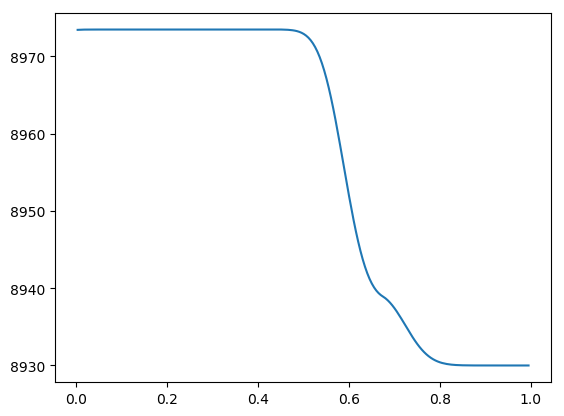

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f229fad9e80>

In [102]:
#plot(x,uo[:,4])
plot(rline,ρline)

In [67]:
rcell, zcell = cell_coordinate(var.r,var.z)

([0.0054879, 0.0104637, 0.0154395, 0.0204153, 0.0253911, 0.0303669, 0.0353426, 0.0403184, 0.0452942, 0.05027  …  0.9525, 0.9575, 0.9625, 0.9675, 0.9725, 0.9775, 0.9825, 0.9875, 0.9925, 0.9975], [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09])

In [71]:
using DelimitedFiles
Output_cell(I,J,var,mz)

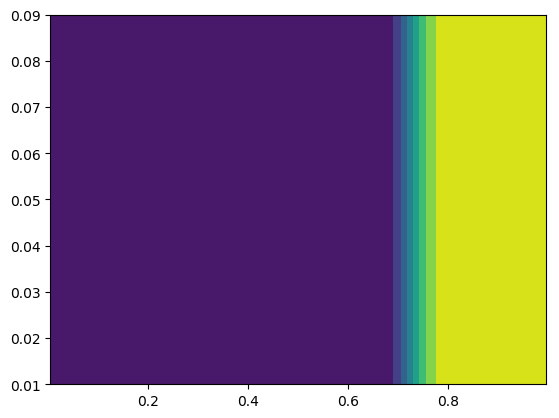

PyObject <matplotlib.tri.tricontour.TriContourSet object at 0x7f27440596a0>

In [68]:
tricontourf(rcell,zcell,var.s[:,1])

In [47]:
 function Pistonz()

    global problem = prb(1.5e-4,0.3)
    # global problem = prb(3e-5,0.3)
     
    I = 10
    J = 100
    dx = 0.1/I
    dy = 1/J
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    IBL = J+1
    IBR = J+1
    IBU = I+1
    IBD = I+1
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

# Bound 
  ib = 0
    for i = 1:I+1
        for j = 1:J+1
            if i == 1 || i== I+1 ||  j == 1 || j == J+1
                ib += 1
                ic =i+(j-1)*I
                #ic = Tc[ip]
                Tb[ib,1] = ic
                if i==1 
                    Tb[ib,2] = 4 # 1->4 
                    Tb[ib,3] = 2 # type 1:free 2:
                end   
                 if  i==I+1 
                    Tb[ib,2] = 2 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tb[ib,3] = 2
                end
            
                if j==1 
                    Tb[ib,2] = 1
                    Tb[ib,3] = 1
                end
                if j==J+1
                    Tb[ib,2] = 3 
                    Tb[ib,3] = 1
                end
            end
        end
    end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    σ = zeros(Float64,Ic,3)
    
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            x[ip] = (i-1)*dx
            y[ip] = (j-1)*dy
            u[ip] = 0
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i>=I/2
               
                p[ic] = 1.e5
                ρ[ic] = 8930
                mz[ic] = ρ[ic] * Az[ic]
                σ[ic,1] = -p[ic]
                σ[ic,2] = -p[ic]
                σ[ic,3]= 0 
#             else
#                 mz[ic] = 1.0 * Az[ic]
#                 p[ic] = 1.0
#                 ρ[ic] = 1.0
#             end
        end
    end
    var = Var(x,y,u,v,ρ,p,σ)
    return var,mz,I,J
end

Pistonz (generic function with 1 method)

In [48]:
var,mz,I,J=Pistonz()
#Output1
var = TimeSolve(var,mz)

UndefVarError: UndefVarError: Bound not defined

In [49]:
rcell, zcell = cell_coordinate(var.r,var.z)

([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095  …  0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095], [0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005  …  0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995])

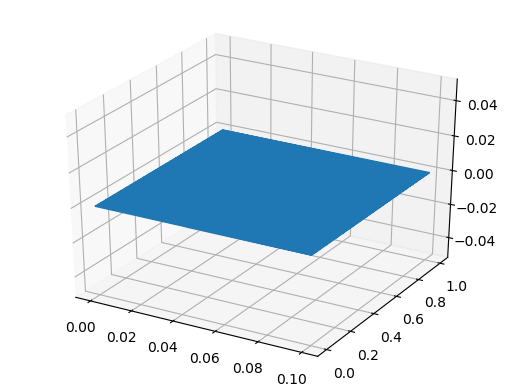

1-element Array{PyCall.PyObject,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7fbfd0b04da0>

In [50]:
plot3D(var.r,var.z,var.v)
#triplot()

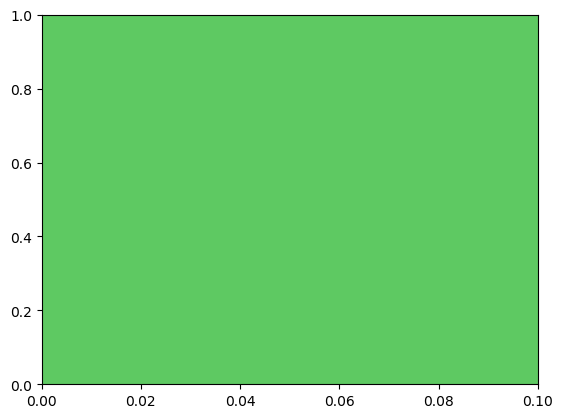

PyObject <matplotlib.tri.tricontour.TriContourSet object at 0x7fbfb46c0d68>

In [51]:
tricontourf(var.r,var.z,var.v)

In [53]:
? Const

search: Const const isconst MathConstants @colorant_str codeunits ncodeunits



No documentation found.

# Summary

```
struct Const <: Any
```

# Fields

```
Y0 :: Float64
ρ0 :: Float64
Γ0 :: Float64
μ  :: Float64
a0 :: Float64
s0 :: Float64
```


## 单位变换

$$ 1kg/m^3 = 10^{-3} g/cm^3$$
$$1m/s = 10^{-4} cm/\mu s$$
$$ 1Pa = 1N/m^2 = 1kg/(m\cdot s^2) = (1000g)/(100cm \cdot 10^{12} \mu s^2) = 10^{-11} g/(cm \cdot s^2)$$ 

In [44]:
 function Collapse()

    global problem = prb(1.3e2,0.1)
    # global problem = prb(5e-5,0.3)
    
    I = 20
    J = 16
    dr = 2.0/J
    dθ = 90/I
    
    global   con1 = Const(3.3e-3,1.845,2.0,1.519,1.287,1.124)
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    IBL = J+1
    IBR = J+1
    IBU = I+1
    IBD = I+1
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

  ib = 0
        for j = 1:J
           # if i == 1 || i== I ||  j == 1 || j == J
            for i in (1,I)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
                if i==1 
                    Tb[ib,2] = 4
                    Tb[ib,3] = 4
                    
                end   
                 if  i==I 
                    Tb[ib,2] = 2 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tb[ib,3] = 4
                end
                
    
            end
        end
      for i = 1:I
           # if i == 1 || i== I ||  j == 1 || j == J
            for j in (1,J)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = 1
                    Tb[ib,3] = 1
                end
                if j==J
                    Tb[ib,2] = 3
                    Tb[ib,3] = 1
                end
            end
        end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            r₁ = (j-1)*dr+8
            θ = 90-(i-1)*dθ
            v₀ = 4.171e-2
            x[ip] = cosd(θ)*r₁
            y[ip] = sind(θ)*r₁
            u[ip] = -v₀*8/r₁ *cosd(θ)
            v[ip] = -v₀*8/r₁ *sind(θ)
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i>=I/2
               
                p[ic] = 1.e-5
                ρ[ic] = 1.845
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0
                
#             else
#                 mz[ic] = 1.0 * Az[ic]
#                 p[ic] = 1.0
#                 ρ[ic] = 1.0
#             end
        end
    end
    var = Var(x,y,u,v,ρ,p,s)
    return var,mz,I,J
end

Collapse (generic function with 1 method)

In [45]:
var,mz,I,J = Collapse()
var = TimeSolve(var,mz)
#using DelimitedFiles
#Output_cell(I,J,var,mz)

1.3068714782655597
2.6063836408697956
3.9000247411846534
5.201773627403851
6.504079421046879
7.807091425559102
9.101214576560714
10.400613759825735
11.705433357872062
13.000675595945207
14.301036829253365
15.606906726543302
16.902671505687547
18.2036390652649
19.502177510594535
20.805775671562674
22.106807632622324
23.405094634894805
24.700520864500795
26.00098572529071
27.30637761658341
28.600840460214982
29.900166256901937
31.204290585020978
32.505224540916544
33.802833272659804
35.105112660457685
36.40395617811753
37.7073832987566
39.00720576379756
40.30333511318126
41.603884137991756
42.90058368310256
44.20162952377611
45.506981348997655
46.80828247191605
48.105418595645325
49.40668345287342
50.703633141169746
52.00461100848234
53.301097786393626
54.60151231135252
55.90581216512506
57.20540164586147
58.500183267875585
59.807261604280875
61.10076787024846
62.406507813404716
63.70714036559271
65.00255743878468
66.30138607220536
67.60357828201943
68.9003197438412
70.20030271843282
71.

Var([0.0, 0.391975, 0.781534, 1.16627, 1.54382, 1.91185, 2.2681, 2.61036, 2.93653, 3.24459  …  5.93735, 6.31691, 6.65752, 6.95709, 7.21377, 7.42597, 7.59239, 7.712, 7.78406, 7.80813], [4.99592, 4.98052, 4.93441, 4.85788, 4.7514, 4.61563, 4.4514, 4.25972, 4.04178, 3.79892  …  5.07097, 4.5895, 4.07974, 3.54482, 2.98804, 2.41284, 1.82277, 1.22146, 0.612615, 0.0], [-1.00604e-9, 2.50901e-5, 5.00214e-5, 7.46368e-5, 9.87961e-5, 0.00012236, 0.000145172, 0.000167069, 0.000187926, 0.000207646  …  0.000178019, 0.0001894, 0.000199607, 0.000208581, 0.000216276, 0.000222648, 0.000227659, 0.000231247, 0.000233363, 0.000234054], [0.000319728, 0.000318735, 0.000315778, 0.000310889, 0.000304105, 0.000295426, 0.000284886, 0.000272596, 0.000258656, 0.000243137  …  0.000152038, 0.000137606, 0.000122325, 0.000106288, 8.95858e-5, 7.23218e-5, 5.4629e-5, 3.66342e-5, 1.84034e-5, 6.31392e-10], [1.84401, 1.84401, 1.84401, 1.84401, 1.84401, 1.84401, 1.84401, 1.84401, 1.84401, 1.84401  …  1.84498, 1.84498, 1.84498,

In [139]:
using DelimitedFiles
Output_cell(I,J,var,mz)

s = [-0.00183435 0.00185163 7.24084e-5; -0.00182299 0.00184026 0.000216774; -0.00180033 0.0018176 0.000359806; -0.00176652 0.00178379 0.000500628; -0.00172177 0.00173905 0.000638372; -0.00166637 0.00168364 0.000772193; -0.00160063 0.00161789 0.000901256; -0.00152495 0.00154221 0.00102475; -0.00143981 0.00145708 0.00114189; -0.00134575 0.00136302 0.00125197; -0.00124335 0.00126062 0.00135436; -0.00113323 0.0011505 0.00144843; -0.00101607 0.00103334 0.00153358; -0.000892593 0.000909863 0.00160925; -0.000763578 0.000780843 0.001675; -0.000629792 0.00064705 0.00173043; -0.00049203 0.000509289 0.0017752; -0.000351159 0.000368425 0.001809; -0.000208094 0.00022537 0.00183162; -6.37442e-5 8.10252e-5 0.00184296; 8.10252e-5 -6.37442e-5 0.00184296; 0.00022537 -0.000208094 0.00183162; 0.000368425 -0.000351159 0.001809; 0.000509289 -0.00049203 0.0017752; 0.00064705 -0.000629792 0.00173043; 0.000780843 -0.000763578 0.001675; 0.000909863 -0.000892593 0.00160925; 0.00103334 -0.00101607 0.00153358; 0.0

In [46]:
tmp =0.0
for i in 1:21
   tmp += √(var.r[i]^2 + var.z[i]^2)
end
@show tmp/21

tmp / 21 = 4.995916082901026


4.995916082901026

In [47]:
tmax =0.0
for i in 1:21
    tmp2 = √(var.r[i]^2 + var.z[i]^2)
    if abs(tmp2 - tmp/21) >tmax
        tmax = abs(tmp2-tmp/21)
    end
end
@show tmax

tmax = 1.7882150507020356e-6


1.7882150507020356e-6

In [109]:
tmp

104.91433376444179

In [127]:
 rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)

Ic, = size(Tp) 
for i in 1:Ic
        for j =1:4
            rcell[j] = var.r[Tp[i,j]]
            zcell[j] = var.z[Tp[i,j]]
            ucell[j] = var.u[Tp[i,j]]
            vcell[j] = var.v[Tp[i,j]]
        end
        Az = sum(A_z(rcell,zcell))
@show Az
end

Az = 1.6419662776071194e-6
Az = 1.6419678384125289e-6
Az = 1.6419698003352593e-6
Az = 1.6419715654210853e-6
Az = 1.6419731572467691e-6
Az = 1.641974608095325e-6
Az = 1.641975941807925e-6
Az = 1.6419771743152395e-6
Az = 1.6419783096624269e-6
Az = 1.6419793388436701e-6
Az = 1.6419802502085665e-6
Az = 1.6419810420707477e-6
Az = 1.6419817232254247e-6
Az = 1.6419823111354622e-6
Az = 1.6419828174849818e-6
Az = 1.6419832423586597e-6
Az = 1.6419835836882718e-6
Az = 1.6419838425131344e-6
Az = 1.6419840210321179e-6
Az = 1.6419841192303686e-6
Az = 1.6419841192313444e-6
Az = 1.6419840210315758e-6
Az = 1.6419838425136765e-6
Az = 1.6419835836878382e-6
Az = 1.6419832423583344e-6
Az = 1.6419828174855239e-6
Az = 1.6419823111348117e-6
Az = 1.6419817232245573e-6
Az = 1.641981042071073e-6
Az = 1.6419802502072112e-6
Az = 1.6419793388439412e-6
Az = 1.6419783096627521e-6
Az = 1.6419771743149143e-6
Az = 1.6419759418077082e-6
Az = 1.641974608094783e-6
Az = 1.641973157246471e-6
Az = 1.6419715654211666e-6
Az = 1

Az = 1.7567941432873732e-6
Az = 1.756793928400671e-6
Az = 1.7567936446464226e-6
Az = 1.7567932968799022e-6
Az = 1.756792884058324e-6
Az = 1.7567924085086029e-6
Az = 1.7567918687585006e-6
Az = 1.7567912605787614e-6
Az = 1.7567905901741659e-6
Az = 1.7567898498652016e-6
Az = 1.7567890116599368e-6
Az = 1.7567880575337816e-6
Az = 1.7567869878253864e-6
Az = 1.7567858017142812e-6
Az = 1.7567844938249917e-6
Az = 1.756783051287252e-6
Az = 1.756781450354785e-6
Az = 1.7567819602281446e-6
Az = 1.7695408725087439e-6
Az = 1.7695403904759952e-6
Az = 1.76954196055257e-6
Az = 1.7695433768795865e-6
Az = 1.7695446653991976e-6
Az = 1.7695458344792756e-6
Az = 1.769546879797784e-6
Az = 1.769547800027822e-6
Az = 1.7695486110131612e-6
Az = 1.7695493353725358e-6
Az = 1.769549993384592e-6
Az = 1.769550591082373e-6
Az = 1.7695511222856012e-6
Az = 1.769551590883418e-6
Az = 1.7695519987684068e-6
Az = 1.7695523428805154e-6
Az = 1.769552621395899e-6
Az = 1.7695528358592201e-6
Az = 1.7695529823129243e-6
Az = 1.769553

Az = 1.8843888401810392e-6
Az = 1.8843896058964383e-6
Az = 1.8843903114868638e-6
Az = 1.8843909530873518e-6
Az = 1.8843915457129098e-6
Az = 1.8843920904692071e-6
Az = 1.8843925825048728e-6
Az = 1.8843930223913898e-6
Az = 1.8843934058201386e-6
Az = 1.8843937322321046e-6
Az = 1.8843939977137517e-6
Az = 1.884394199664621e-6
Az = 1.8843943395548905e-6
Az = 1.8843944124050365e-6
Az = 1.8843944124059039e-6
Az = 1.8843943395559747e-6
Az = 1.8843941996650546e-6
Az = 1.8843939977141854e-6
Az = 1.884393732231671e-6
Az = 1.8843934058216565e-6
Az = 1.8843930223895466e-6
Az = 1.884392582504656e-6
Az = 1.8843920904703998e-6
Az = 1.884391545711934e-6
Az = 1.8843909530870265e-6
Az = 1.8843903114868638e-6
Az = 1.8843896058962214e-6
Az = 1.8843888401802802e-6
Az = 1.8843880069342104e-6
Az = 1.8843870505582273e-6
Az = 1.8843859196018419e-6
Az = 1.884384624834597e-6
Az = 1.8843831992549042e-6
Az = 1.8843834061914975e-6
Az = 1.8971448618677599e-6
Az = 1.8971446855903847e-6
Az = 1.8971461045137403e-6
Az = 1

Az = 1.999249111229724e-6
Az = 1.999248353616351e-6
Az = 1.999247531118682e-6
Az = 1.9992466252583344e-6
Az = 1.9992456229936026e-6
Az = 1.999244540038127e-6
Az = 1.999243266240938e-6
Az = 1.9992431023590023e-6
Az = 2.0120060379959364e-6
Az = 2.012006322057075e-6
Az = 2.012007546154152e-6
Az = 2.012008624903113e-6
Az = 2.0120096274287035e-6
Az = 2.0120105288005084e-6
Az = 2.0120113622665086e-6
Az = 2.0120121193359375e-6
Az = 2.0120128173454046e-6
Az = 2.0120134621516616e-6
Az = 2.0120140619405433e-6
Az = 2.0120146157860327e-6
Az = 2.0120151181563135e-6
Az = 2.01201556766133e-6
Az = 2.012015964059956e-6
Az = 2.012016303147004e-6
Az = 2.0120165776531165e-6
Az = 2.012016788450208e-6
Az = 2.0120169328631185e-6
Az = 2.0120170075316884e-6
Az = 2.0120170075299537e-6
Az = 2.012016932863769e-6
Az = 2.01201678844869e-6
Az = 2.0120165776542007e-6
Az = 2.012016303146137e-6
Az = 2.0120159640606063e-6
Az = 2.0120155676604627e-6
Az = 2.0120151181552293e-6
Az = 2.0120146157851654e-6
Az = 2.01201406194

In [145]:
 function Impact()

    global problem = prb(1.3e2,0.1)
    # global problem = prb(5e-5,0.3)
    
    I = 100
    J = 20
    dx = 5/I
    dy = 1/J
    
    global   con1 = Const(3e-3,2.785,2.0,2.75e-1,0.5328,1.338)
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

  ib = 0
        for j = 1:J
           # if i == 1 || i== I ||  j == 1 || j == J
            for i in (1,I)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
                if i==1 
                    Tb[ib,2] = 4
                    Tb[ib,3] = 4
                    
                end   
                 if  i==I 
                    Tb[ib,2] = 2 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tb[ib,3] = 1
                end
                
    
            end
        end
      for i = 1:I
           # if i == 1 || i== I ||  j == 1 || j == J
            for j in (1,J)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = 1
                    Tb[ib,3] = 1
                end
                if j==J
                    Tb[ib,2] = 3
                    Tb[ib,3] = 1
                end
            end
        end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    ϵ = 1/2*dy
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
           
            x[ip] = (i-1)*dx
            y[ip] = (j-1)*dy
            u[ip] = -1.50e-2
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i>=I/2
               
                p[ic] = 1.e-5
                ρ[ic] = 2.785
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0
        end
    end
    var = Var(x,y,u,v,ρ,p,s)
    return var,mz,I,J
end

Impact (generic function with 1 method)

In [ ]:
var,mz,I,J = Impact()
var = TimeSolve(var,mz)
using DelimitedFiles
Output_cell(I,J,var,mz)

1.3014865345246551
2.605145772600472
3.9015167893875247
5.204989692223499
6.5028203820278385
7.801935641351191
9.10100011649691
10.404183758951751
11.701717037356376
13.00326962209035
14.303270993804688
15.602302730317227
16.904542495439888
18.204030873840466
19.503300379291105


In [103]:
using DelimitedFiles
Output_cell(I,J,var,mz)

s = [-1.55192e8 1.57822e8 -8.52346e5; -1.637e8 1.63972e8 -5.67432e5; -1.70802e8 1.75505e8 1.12435e6; -1.71031e8 1.75254e8 2.87049e6; -1.71401e8 1.74873e8 3.82834e6; -1.71609e8 1.74697e8 3.29061e6; -1.71813e8 1.7449e8 3.64108e6; -1.71918e8 1.74267e8 5.89937e6; -1.71814e8 1.73921e8 1.06484e7; -1.7135e8 1.73303e8 1.73387e7; -1.70434e8 1.72295e8 2.51313e7; -1.68938e8 1.70785e8 3.38298e7; -1.66747e8 1.68687e8 4.32224e7; -1.63918e8 1.65905e8 5.29269e7; -1.60292e8 1.62526e8 6.27973e7; -1.55945e8 1.5823e8 7.29355e7; -1.52148e8 1.54593e8 8.04549e7; -1.47356e8 1.50352e8 8.85196e7; -1.39297e8 1.42464e8 1.00723e8; -1.31257e8 1.31135e8 1.13082e8; -1.33805e8 1.30937e8 1.11677e8; -1.49392e8 1.44584e8 9.06578e7; -1.54778e8 1.44495e8 6.6155e7; -1.5564e8 1.41081e8 5.01644e7; -1.64093e8 1.4711e8 3.94474e7; -1.72163e8 1.53478e8 4.45711e7; -1.71963e8 1.50579e8 6.01878e7; -1.73114e8 1.49445e8 5.97397e7; -1.72313e8 1.45424e8 6.49502e7; -1.74443e8 1.4569e8 6.13084e7; -1.74047e8 1.44828e8 4.97508e7; -1.71081e8

In [241]:
max(i for i in var.σ[1:end,3])

MethodError: MethodError: no method matching max(::Base.Generator{Array{Float64,1},getfield(Main, Symbol("##31#32"))})
Closest candidates are:
  max(::Any, !Matched::Missing) at missing.jl:107
  max(::Any, !Matched::Any) at operators.jl:400
  max(::Any, !Matched::Any, !Matched::Any, !Matched::Any...) at operators.jl:502
  ...

In [239]:
? max

search: max maximum maximum! maxintfloat argmax typemax findmax findmax!



```
max(x, y, ...)
```

Return the maximum of the arguments. See also the [`maximum`](@ref) function to take the maximum element from a collection.

# Examples

```jldoctest
julia> max(2, 5, 1)
5
```


In [249]:
using DelimitedFiles
Output_cell(I,J,var,mz)

In [197]:
(2.95-2.62)/2.62

0.12595419847328246